# QPyTorch regression with derivative information in 2d

## Introduction
In this notebook, we show how to train a QEP regression model in QPyTorch of a 2-dimensional function given function values and derivative observations. We consider modeling the Rosenbrock and Rastrigin functions where the values and derivatives are contaminated with independent $\mathcal{N}(0, 0.05^2)$ distributed noise.

In [1]:
import torch
import qpytorch
import math
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Rosenbrock function
The following is a vectorized implementation of the 2-dimensional Rosenbrock function (https://en.wikipedia.org/wiki/Rosenbrock_function)

In [2]:
def rosenbrock(tensor, lib=torch):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    if type(tensor) is list:
        x, y = tensor
    else:
        x, y = lib.split(tensor, (1, 1))
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

def rosenbrock_grad(tensor, lib=torch):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    if type(tensor) is list:
        x, y = tensor
    else:
        x, y = lib.split(tensor, (1, 1))
    return torch.cat([-(1 - x) * 2 - 100 * (y - x ** 2) * 4 * x,
                      100 * (y - x ** 2) * 2])

## Setting up the training data
We use a grid with 400 points in $[0,1] \times [0,1]$ with 20 uniformly distributed points per dimension.

In [3]:
xlim, ylim = [[-2,2],[-1,3]]
nx, ny = 20, 20
xv, yv = torch.meshgrid(torch.linspace(xlim[0], xlim[1], nx), torch.linspace(ylim[0], ylim[1], ny), indexing="xy")
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

f = rosenbrock(train_x.T)
df = rosenbrock_grad(train_x.T)
train_y = torch.cat([f, df]).T.squeeze(1)

train_y += 0.05 * torch.randn(train_y.size()) # Add noise to both values and gradients

## Setting up the model
A QEP prior on the function values implies a multi-output QEP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateQExponential` and `MultitaskQExponentialLikelihood` to train a QEP model from both function values and gradients. The resulting Matern52 kernel that models the covariance between the values and partial derivatives has been implemented in `Matern52KernelGrad` and the extension of a constant mean is implemented in `ConstantMeanGrad`.

In [4]:
class QEPModelWithDerivatives(qpytorch.models.ExactQEP):
    def __init__(self, power, train_x, train_y):
        self.power = torch.tensor(power)
        likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=3, power=self.power)  # Value + x-derivative + y-derivative
        super(QEPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = qpytorch.means.ConstantMeanGrad()
        self.base_kernel = qpytorch.kernels.Matern52KernelGrad(ard_num_dims=2)
        self.covar_module = qpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=self.power)

model = QEPModelWithDerivatives(1.0, train_x, train_y)

The model training is similar to training a standard QEP regression model

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 8.440   lengthscales: 0.693, 0.693   noise: 0.693
Iter 2/50 - Loss: 8.311   lengthscales: 0.668, 0.718   noise: 0.669
Iter 3/50 - Loss: 8.179   lengthscales: 0.644, 0.744   noise: 0.645
Iter 4/50 - Loss: 8.080   lengthscales: 0.621, 0.771   noise: 0.621
Iter 5/50 - Loss: 7.962   lengthscales: 0.599, 0.798   noise: 0.598
Iter 6/50 - Loss: 7.864   lengthscales: 0.577, 0.825   noise: 0.576
Iter 7/50 - Loss: 7.768   lengthscales: 0.556, 0.853   noise: 0.554
Iter 8/50 - Loss: 7.683   lengthscales: 0.536, 0.881   noise: 0.532
Iter 9/50 - Loss: 7.590   lengthscales: 0.517, 0.909   noise: 0.512
Iter 10/50 - Loss: 7.513   lengthscales: 0.499, 0.937   noise: 0.491
Iter 11/50 - Loss: 7.427   lengthscales: 0.482, 0.966   noise: 0.472
Iter 12/50 - Loss: 7.366   lengthscales: 0.466, 0.994   noise: 0.452
Iter 13/50 - Loss: 7.313   lengthscales: 0.451, 1.022   noise: 0.434
Iter 14/50 - Loss: 7.234   lengthscales: 0.437, 1.051   noise: 0.415
Iter 15/50 - Loss: 7.196   lengthscales: 0.

Model predictions are also similar to QEP regression with only function values, but we need more CG iterations to get accurate estimates of the predictive variance

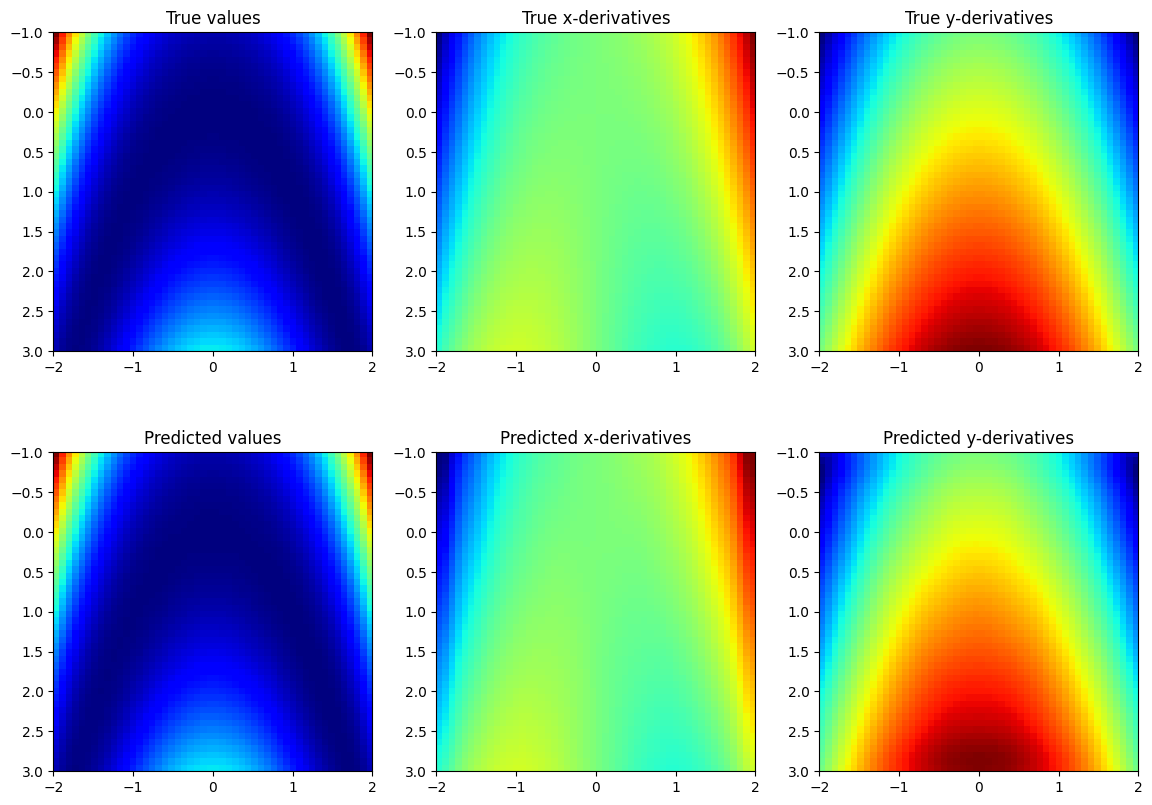

In [6]:
# Set into eval mode
model.eval()

# Initialize plots
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

# Test points
n1, n2 = 50, 50
xv, yv = torch.meshgrid(torch.linspace(xlim[0], xlim[1], n1), torch.linspace(ylim[0], ylim[1], n2), indexing="xy")
f = rosenbrock([xv, yv])
dfx, dfy = rosenbrock_grad([xv, yv]).split([n1, n2])

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = model.likelihood(model(test_x))
    mean = predictions.mean

extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0, 0].imshow(f, extent=extent, cmap=cm.jet)
ax[0, 0].set_title('True values')
ax[0, 1].imshow(dfx, extent=extent, cmap=cm.jet)
ax[0, 1].set_title('True x-derivatives')
ax[0, 2].imshow(dfy, extent=extent, cmap=cm.jet)
ax[0, 2].set_title('True y-derivatives')

ax[1, 0].imshow(mean[:, 0].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 0].set_title('Predicted values')
ax[1, 1].imshow(mean[:, 1].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 1].set_title('Predicted x-derivatives')
ax[1, 2].imshow(mean[:, 2].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 2].set_title('Predicted y-derivatives')

None

## Rastrigin function

Now we consider a more challenging example: 2d Rastrigin fucntion (https://en.wikipedia.org/wiki/Rastrigin_function). We will compare the performance between QEP and GP.

In [7]:
def rastrigin(tensor, lib=torch):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    if type(tensor) is list:
        x, y = tensor
    else:
        x, y = lib.split(tensor, (1, 1))
    A = 10
    f = (
        A * 2
        + (x ** 2 - A * lib.cos(x * lib.pi * 2))
        + (y ** 2 - A * lib.cos(y * lib.pi * 2))
    )
    return f

def rastrigin_grad(tensor, lib=torch):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    if type(tensor) is list:
        x, y = tensor
    else:
        x, y = lib.split(tensor, (1, 1))
    A = 10
    df = [
        (x * 2 + A * lib.sin(x * lib.pi * 2) * lib.pi * 2),
        (y * 2 + A * lib.sin(y * lib.pi * 2) * lib.pi * 2)
    ]
    return torch.cat(df)

## Setting up the training data
We use the same grid with 400 points in $[0,1] \times [0,1]$ with 20 uniformly distributed points per dimension.

In [8]:
xlim, ylim = [[-5,5],[-5,5]]
nx, ny = 20, 20
xv, yv = torch.meshgrid(torch.linspace(xlim[0], xlim[1], nx), torch.linspace(ylim[0], ylim[1], ny), indexing="xy")
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

f = rastrigin(train_x.T)
df = rastrigin_grad(train_x.T)
train_y = torch.cat([f, df]).T.squeeze(1)

train_y += 0.05 * torch.randn(train_y.size()) # Add noise to both values and gradients

## Setting up the models
We define QEP ($q=1.0$) and GP ($q=2.0$) and train them respectively.

In [9]:
# this is for running the notebook in our testing framework
import tqdm
num_epochs = 2 if smoke_test else 100

# Consider GP first
gp = QEPModelWithDerivatives(2.0, train_x, train_y)

# Find optimal model hyperparameters
gp.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)

training_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in training_iter:
    optimizer.zero_grad()
    output = gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    training_iter.set_postfix(loss=loss.item(), noise=gp.likelihood.noise.item())
    # print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
    #     i + 1, training_iter, loss.item(),
    #     gp.covar_module.base_kernel.lengthscale.squeeze()[0],
    #     gp.covar_module.base_kernel.lengthscale.squeeze()[1],
    #     gp.likelihood.noise.item()
    # ))
    optimizer.step()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
# Then consider QEP
qep = QEPModelWithDerivatives(1.0, train_x, train_y)

# Find optimal model hyperparameters
qep.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(qep.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(qep.likelihood, qep)

training_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in training_iter:
    optimizer.zero_grad()
    output = gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    training_iter.set_postfix(loss=loss.item(), noise=qep.likelihood.noise.item())
    optimizer.step()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Now we evaluate the models and compare their reproduced results.

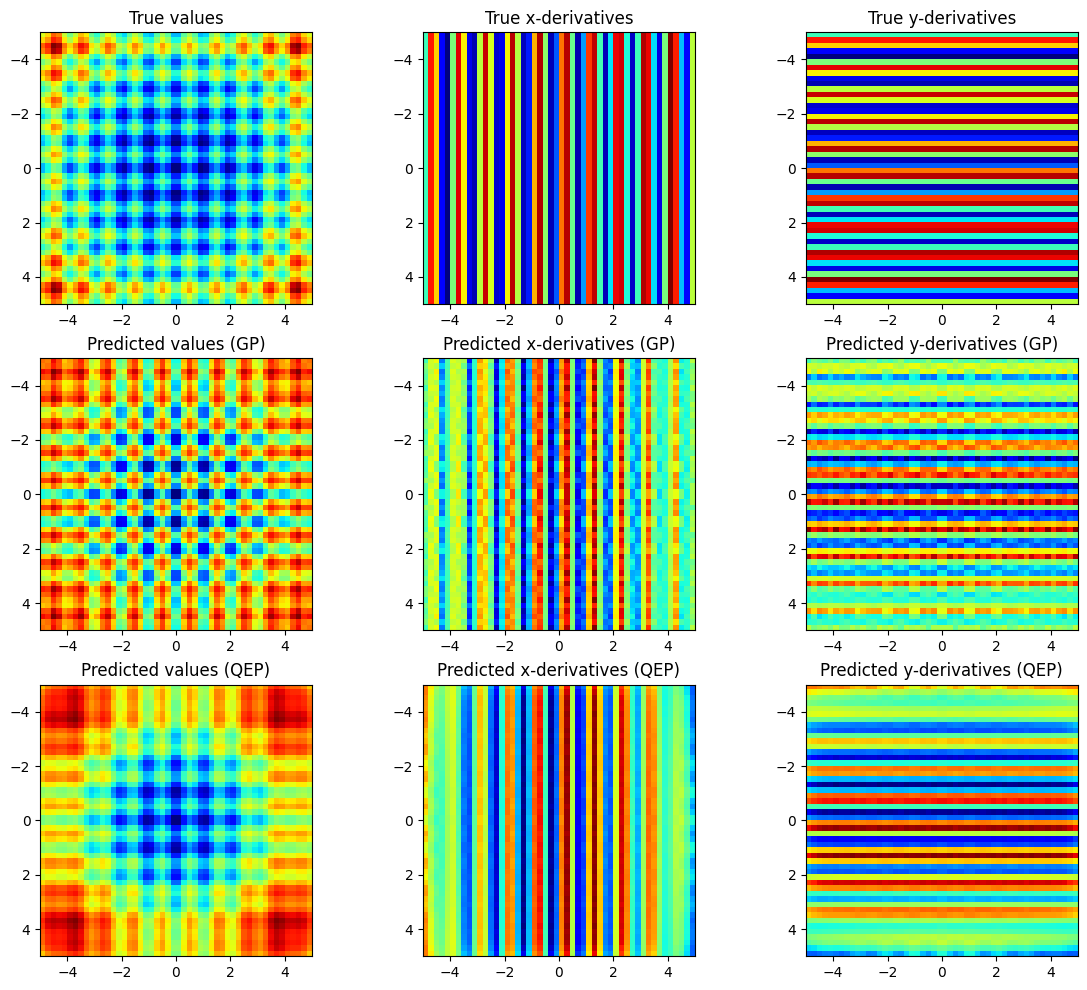

In [11]:
# Initialize plots
fig, ax = plt.subplots(3, 3, figsize=(14, 12))

# Test points
n1, n2 = 50, 50
xv, yv = torch.meshgrid(torch.linspace(xlim[0], xlim[1], n1), torch.linspace(ylim[0], ylim[1], n2), indexing="xy")
f = rastrigin([xv, yv])
dfx, dfy = rastrigin_grad([xv, yv]).split([n1, n2])

extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0, 0].imshow(f, extent=extent, cmap=cm.jet)
ax[0, 0].set_title('True values')
ax[0, 1].imshow(dfx, extent=extent, cmap=cm.jet)
ax[0, 1].set_title('True x-derivatives')
ax[0, 2].imshow(dfy, extent=extent, cmap=cm.jet)
ax[0, 2].set_title('True y-derivatives')

# Make predictions
# Set GP into eval mode
gp.eval()
with torch.no_grad(), qpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = gp.likelihood(gp(test_x))
    mean = predictions.mean

ax[1, 0].imshow(mean[:, 0].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 0].set_title('Predicted values (GP)')
ax[1, 1].imshow(mean[:, 1].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 1].set_title('Predicted x-derivatives (GP)')
ax[1, 2].imshow(mean[:, 2].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 2].set_title('Predicted y-derivatives (GP)')

# Set QEP into eval mode
qep.eval()
with torch.no_grad(), qpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = qep.likelihood(qep(test_x))
    mean = predictions.mean

ax[2, 0].imshow(mean[:, 0].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[2, 0].set_title('Predicted values (QEP)')
ax[2, 1].imshow(mean[:, 1].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[2, 1].set_title('Predicted x-derivatives (QEP)')
ax[2, 2].imshow(mean[:, 2].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[2, 2].set_title('Predicted y-derivatives (QEP)')

None